In [ ]:
%pip install opencv-contrib-python

# Bagian Baru

In [4]:
import cv2 as cv
import numpy as np
from google.colab import drive
from google.colab.patches import cv2_imshow
import glob
import pandas as pd

In [5]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
def load_img(path):
  list_of_buah = []
  for name in glob.glob(path + "/*.jpg") :
    buah = cv.imread(name)
    buah = cv.resize(buah, (300, 300))
    list_of_buah.append(buah)
  return list_of_buah

## **Segmentation Function**

In [7]:
def seg_img(imgs) :
  segementasi = []
  masks = []
  for img in imgs :
    img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    lower_yellow = np.array([0,80,70]) #NILAI BGR LOW, PAKE COLOR PICKER DI PHOTOSHOP
    upper_yellow = np.array([200,250,230])#SAMA AJA KAYAK DI ATAS
    mask = cv.inRange(img_hsv, lower_yellow, upper_yellow)
    res = cv.bitwise_and(img, img, mask= mask)
    segementasi.append(res)
    masks.append(mask)
  return segementasi, masks

# Saving Data to Gdrive

In [8]:
def save_imgs(path, imgs, prefix):
  for i, img in enumerate(imgs) :
    save_path = path + "/" + prefix
    isSaved = cv.imwrite(save_path + str(i) + ".jpg", img)
    if isSaved :
      continue
    else :
      print("ERROR ")
      break

## Shape Extraction Function

In [9]:
def get_areas(imgs):
  areas = []
  for img in imgs:
    contours,hierarchy = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    c = max(contours, key = cv.contourArea)
    area = cv.contourArea(c)
    areas.append(area)
  return areas

In [10]:
def get_perims(imgs):
  perims = []
  for img in imgs:
    contours,hierarchy = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    c = max(contours, key = cv.contourArea)
    perim = cv.arcLength(c,True)
    perims.append(perim)
  return perims

## Color Extraction Function

In [11]:
def get_means(imgs):
  seg_img = np.array(imgs.copy())
  seg_img_r = seg_img[:,:,:,2]
  seg_img_g = seg_img[:,:,:,1]
  seg_img_b = seg_img[:,:,:,0]

  means = []
  for i in range(seg_img.shape[0]):
    reds = seg_img_r[i].copy().flatten()
    green = seg_img_g[i].copy().flatten()
    blue = seg_img_b[i].copy().flatten()
    r_n = np.count_nonzero(reds > 0)
    g_n = np.count_nonzero(green > 0)
    b_n = np.count_nonzero(blue > 0)
    r_sum = np.sum(reds)
    g_sum = np.sum(green)
    b_sum = np.sum(blue)
    r_avg = r_sum / r_n
    g_avg = g_sum / g_n
    b_avg = b_sum / b_n
    means.append([r_avg, g_avg, b_avg])
  return means

In [12]:
def get_means_2(imgs):
  means = []
  for img in imgs:
    mean = cv.mean(img)
    means.append([mean[2], mean[1], mean[0]])
  return means


## Pandas Data Frame Generator

In [13]:
def generate_df_1(segmentation, label_name) :
  masks = get_mask(segmentation)
  areas = get_areas(masks)
  perims = get_perims(masks)
  means = get_means(segmentation)
  feature_df = pd.DataFrame(perims, columns=["perimiter"])
  feature_df["area"] = areas
  means_df = pd.DataFrame(means, columns=["red", "green", "blue"])
  feature_df = pd.concat([feature_df, means_df], axis=1)
  feature_df["fruit"] = label_name
  return feature_df

def generate_df_2(segmentation, label_name) :
  masks = get_mask(segmentation)
  areas = get_areas(masks)
  perims = get_perims(masks)
  means = get_means_2(segmentation)
  feature_df = pd.DataFrame(perims, columns=["perimiter"])
  feature_df["area"] = areas
  means_df = pd.DataFrame(means, columns=["red", "green", "blue"])
  feature_df = pd.concat([feature_df, means_df], axis=1)
  feature_df["fruit"] = label_name
  return feature_df

In [14]:
def get_mask(imgs) :
  masks = []
  for img in imgs:
    _,thresh = cv.threshold(cv.cvtColor(img, cv.COLOR_BGR2GRAY),1,255,cv.THRESH_BINARY)
    thresh = cv.erode(thresh, np.ones([3, 3]), 1)
    masks.append(thresh)
  return masks

In [15]:
tomats = load_img("gdrive/MyDrive/KUMPULAN FOTO HARAM/BASE IMAGE/TOMATS")
seg_tomat, masks = seg_img(tomats)
# save_imgs("gdrive/MyDrive/KUMPULAN FOTO HARAM/SEGMENTED IMAGE/TOMATS SEGMENTED", seg_tomat, "tomat_")

# Deteksi fitur bentuk gagal

In [16]:
canny_imgs = []
for img in seg_tomat :
  img_new = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  img_new = cv.dilate(img_new, np.ones((3, 3)), 20)
  ed = cv.Canny(img_new, 100, 200)
  canny_imgs.append(ed)

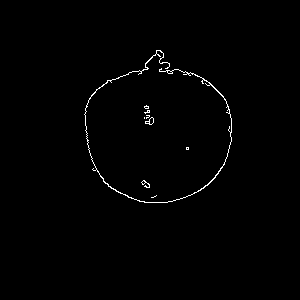

In [18]:
cv2_imshow(canny_imgs[1])

In [ ]:
save_imgs("gdrive/MyDrive/KUMPULAN FOTO HARAM/EDGE DETECTION/TOMATS", canny_imgs, "ed_tomat_")

## Shape Feature Extraction


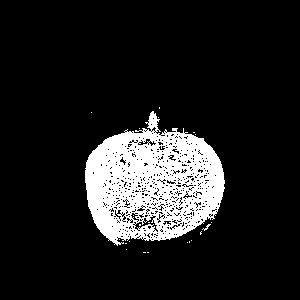

In [ ]:
imgs = masks.copy()
cv2_imshow(imgs[0])

In [ ]:
tomatos_seg = load_img("gdrive/MyDrive/KUMPULAN FOTO HARAM/SEGMENTED IMAGE/TOMATS SEGMENTED")
tomats_feature = generate_df_2(tomatos_seg, "tomato")

In [ ]:
tomats_feature.head()

,perimiter,area,red,green,blue,fruit
0,509.847760,13435.0,21.859467,10.090544,2.048989,tomato
1,453.847759,10747.0,16.723078,6.800400,2.962322,tomato
2,514.374670,15590.5,25.006956,11.685944,2.312433,tomato
3,552.132030,13218.0,28.154322,15.784667,5.770700,tomato
4,563.060962,18561.5,33.234967,19.205144,4.478156,tomato


In [ ]:
apple_seg = load_img("gdrive/MyDrive/KUMPULAN FOTO HARAM/SEGMENTED IMAGE/APPLE SEGMENTED")

In [ ]:
apple_feature_df = generate_df_2(apple_seg, "apple")

In [ ]:
apple_feature_df.head()

,perimiter,area,red,green,blue,fruit
0,557.060963,14229.5,13.143556,4.732400,4.657533,apple
1,741.428494,13037.5,8.736556,2.590644,3.010567,apple
2,681.872145,13621.0,11.735811,3.508222,3.660856,apple
3,745.026472,12638.5,13.014400,3.784867,4.254211,apple
4,560.960457,11865.0,11.647311,3.394744,3.906022,apple


In [ ]:
fear_imgs = load_img("gdrive/MyDrive/KUMPULAN FOTO HARAM/SEGMENTED IMAGE/FEAR SEGMENTED")

In [ ]:
fear_df = generate_df_2(fear_imgs, "pear")

In [ ]:
fear_df.head()

,perimiter,area,red,green,blue,fruit
0,643.303604,10977.0,16.118889,13.051844,7.378333,pear
1,516.291411,8956.5,13.047833,10.517311,5.966189,pear
2,543.261974,10790.5,15.458356,12.493944,7.081856,pear
3,493.220343,9620.0,13.399056,10.706467,5.853567,pear
4,367.865005,7037.5,10.258911,8.197889,4.577478,pear


In [ ]:
banana_imgs = load_img("gdrive/MyDrive/KUMPULAN FOTO HARAM/SEGMENTED IMAGE/BANANA SEGMENTED")
banana_df = generate_df_2(banana_imgs, "banana")
banana_df.head()

,perimiter,area,red,green,blue,fruit
0,309.178713,3051.5,5.696789,3.766611,1.210000,banana
1,504.232535,11327.5,20.644311,15.518889,2.373478,banana
2,293.279218,3136.0,4.796711,3.547978,0.732700,banana
3,314.651802,4052.0,6.666033,5.046267,1.016522,banana
4,483.286358,7151.5,12.741144,9.814167,1.618844,banana


In [ ]:
jeruk_imgs = load_img("gdrive/MyDrive/KUMPULAN FOTO HARAM/SEGMENTED IMAGE/JERUK SEGMENTED")
jeruk_df = generate_df_2(jeruk_imgs, "jeruk")
jeruk_df.head()

,perimiter,area,red,green,blue,fruit
0,363.320848,8196.5,16.320067,12.872144,2.238256,jeruk
1,615.972650,23190.5,48.740500,39.032733,7.515900,jeruk
2,374.492422,8577.5,16.945522,13.321433,4.049722,jeruk
3,511.889390,15831.5,30.955833,25.845789,3.000667,jeruk
4,545.303603,16978.0,31.928589,27.241267,3.528122,jeruk


In [ ]:
data = pd.concat([jeruk_df, banana_df, fear_df, apple_feature_df, tomats_feature])

In [ ]:
data.to_csv("gdrive/MyDrive/KUMPULAN FOTO HARAM/extrated_feature_mean_2.csv")